In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import sys

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModel
# from peft import PeftConfig, PeftModel

import torch

import numpy as np
import pandas as pd
import re

import zipfile

import json

from PIL import Image
from matplotlib import pyplot
import seaborn as sns

from tqdm.auto import tqdm

In [16]:
from utils import get_score_from_embs

In [17]:
BATCH_SIZE = 64

EMB_DIMS = 768

POS_WEIGHT_PATH = './weight/004/environmental/clip_positive.pt'
NEG_WEIGHT_PATH = './weight/004/environmental/clip_negative.pt'
TEXT_WEIGHT_PATH = './weight/004/environmental/clip_text.pt'
VISION_WEIGHT_PATH = './weight/004/environmental/clip_vision.pt'

positive_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
positive_model.load_state_dict(torch.load(POS_WEIGHT_PATH))

negative_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
negative_model.load_state_dict(torch.load(NEG_WEIGHT_PATH))

text_model = torch.nn.Linear(EMB_DIMS * 2, 1, bias=True).cuda().eval()
text_model.load_state_dict(torch.load(TEXT_WEIGHT_PATH))

vision_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
vision_model.load_state_dict(torch.load(VISION_WEIGHT_PATH))

<All keys matched successfully>

In [18]:
def show_images(file_paths):
    
    n_select = len(file_paths)
    
    images = np.stack([np.array(Image.open(file_path)) for file_path in file_paths])
    images = images.reshape(-1, int(n_select ** 0.5), *images.shape[-3:])
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    
    images = Image.fromarray(images).resize((512, 512))
    
    return images

def show_prompts(file_paths):
    
    metas = list()
    
    for file_path in file_paths:
        
        meta = json.load(open(file_path))
        
        metas.append(meta)
        
    return pd.DataFrame(metas)

# load dataset

In [19]:
paths = {
    'empty': './generated/prompt/empty.tsv',
    'pos2neg': './generated/prompt/pos2neg.tsv',
    'neg2pos': './generated/prompt/neg2pos.tsv',
}

In [20]:
prompts = list()

for strategy, path in paths.items():
    
    df = pd.read_csv(path, sep='\t')
    
    df['strategy'] = strategy
    
    prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)

# load model

In [21]:
MAX_LENGTH = 77
MODEL_NAME = 'openai/clip-vit-large-patch14'

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
transformer = AutoModel.from_pretrained(MODEL_NAME, local_files_only=True).text_model.cuda().eval()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [23]:
def text_worker(texts):
    
    batch_encoding = tokenizer(
        texts,
        truncation=True, max_length=MAX_LENGTH, return_length=True,
        return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
    )

    tokens = batch_encoding["input_ids"].cuda()

    clip_text_opt = transformer(input_ids=tokens, output_hidden_states=True, return_dict=True)
    
    pooler_output = clip_text_opt.pooler_output.detach().cpu().numpy()
    
    return pooler_output

def batch_text_worker(texts):
    
    texts = list(texts)
    
    pooler_outputs = list()

    with torch.no_grad():

        for i in tqdm(range(0, len(texts), BATCH_SIZE), leave=False):

            pooler_output = text_worker(texts[i:i+BATCH_SIZE])

            pooler_outputs.append(pooler_output)

    pooler_outputs = np.concatenate(pooler_outputs, axis=0)
    
    return pooler_outputs
    

# get embs

In [24]:
positive_embs = batch_text_worker(prompts['positive_prompt'])
negative_embs = batch_text_worker(prompts['negative_prompt'])

  0%|          | 0/3768 [00:00<?, ?it/s]

  0%|          | 0/3768 [00:00<?, ?it/s]

In [25]:
positive_scores = get_score_from_embs(positive_embs, positive_model, BATCH_SIZE)
negative_scores = get_score_from_embs(negative_embs, negative_model, BATCH_SIZE)
text_scores = get_score_from_embs(np.concatenate([positive_embs, negative_embs], axis=-1), text_model, BATCH_SIZE)

  0%|          | 0/3768 [00:00<?, ?it/s]

  0%|          | 0/3768 [00:00<?, ?it/s]

  0%|          | 0/3768 [00:00<?, ?it/s]

In [26]:
prompts['positive_score'] = positive_scores
prompts['negative_score'] = negative_scores
prompts['text_score'] = text_scores

In [27]:
prompts.to_csv('results-1119.tsv', sep='\t', index=False)
prompts

,negative_length,positive_prompt,negative_prompt,positive_length,positive_base,negative_base,strategy,positive_score,negative_score,text_score
0,NaN,a girl with a red dress and headphones on her ...,"whole body, bad anatomy\finger\+++, missing fi...",NaN,NaN,NaN,empty,-0.510573,1.759884,0.214448
1,NaN,a girl with a red dress and headphones on her ...,"whole body shot', nipples bad-hands-5 negative...",NaN,NaN,NaN,empty,-0.510573,1.270385,-0.072697
2,NaN,a girl with a red dress and headphones on her ...,weird photo bad-hands-5 epicphotogasm-colorful...,NaN,NaN,NaN,empty,-0.510573,0.907573,-0.513760
3,NaN,a girl with a red dress and headphones on her ...,"structurezoov21, photozoov15 structurezoov15 q...",NaN,NaN,NaN,empty,-0.510573,0.586021,-0.919780
4,NaN,a girl with a red dress and headphones on her ...,weird animals weird things wrong shapes bad an...,NaN,NaN,NaN,empty,-0.510573,0.725061,-0.246208
...,...,...,...,...,...,...,...,...,...,...
241114,NaN,"2d environmental side scrolling,whimsical colo...","low_quality, worst qu ality;",NaN,"2D environmental side scrolling,","low_quality,",neg2pos,2.632214,0.566112,3.144631
241115,NaN,"2d environmental side scrolling,whimsical colo...","low_quality, easynegativev2 ng_deepnegativexl ...",NaN,"2D environmental side scrolling,","low_quality,",neg2pos,2.632214,1.445194,3.471718
241116,NaN,"2d environmental side scrolling,whimsical wate...","low_quality, lowres blurry image from back to ...",NaN,"2D environmental side scrolling,","low_quality,",neg2pos,1.518711,1.715390,3.087978
241117,NaN,"2d environmental side scrolling,whimsical wate...","low_quality,photonous color scheme limited edi...",NaN,"2D environmental side scrolling,","low_quality,",neg2pos,1.518711,0.681083,1.867279


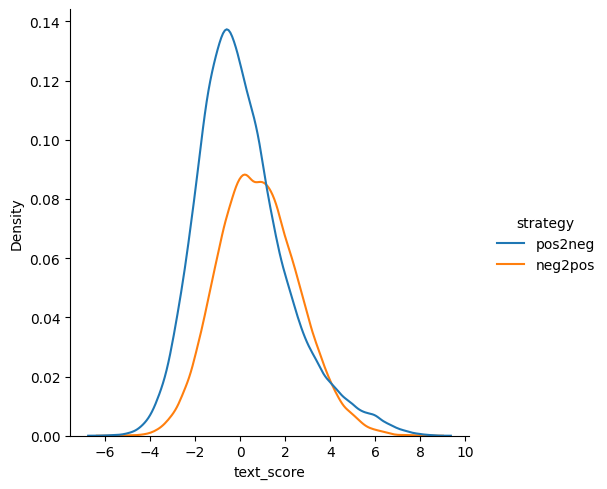

In [14]:
sns.displot(data=prompts, x="text_score", hue="strategy", kind="kde")

# from pre-calculated

In [7]:
OUTPUT_DIR = './generated/'

## from disk

In [8]:
file_names = list()

for file_name in os.listdir(os.path.join(OUTPUT_DIR, 'image')):
    
    embedding_path = os.path.join(OUTPUT_DIR, 'embedding', file_name.replace('.jpg', '.npz'))
    clip_path = os.path.join(OUTPUT_DIR, 'clip', file_name.replace('.jpg', '.npy'))
    
    if not os.path.exists(embedding_path) or not os.path.exists(clip_path):
        continue
        
    file_names.append(file_name)
    
file_names = np.array(file_names)

name_to_index = {file_name: i for i, file_name in enumerate(file_names)}

In [9]:
positive_embs = list()
negative_embs = list()
image_embs = list()
positive_prompts = list()
negative_prompts = list()

for file_name in tqdm(file_names):
    
    embedding_path = os.path.join(OUTPUT_DIR, 'embedding', file_name.replace('.jpg', '.npz'))
    
    npz = np.load(embedding_path)
    positive_embs.append(npz['positive_pooler_output'])
    negative_embs.append(npz['negative_pooler_output'])
    
    clip_path = os.path.join(OUTPUT_DIR, 'clip', file_name.replace('.jpg', '.npy'))
    
    image_embs.append(np.load(clip_path))
    
    meta_path = os.path.join(OUTPUT_DIR, 'meta', file_name.replace('.jpg', '.json'))
    
    meta = json.load(open(meta_path))
    
    positive_prompts.append(meta['positive_prompt'])
    negative_prompts.append(meta['negative_prompt'])
    
positive_embs = np.concatenate(positive_embs, axis=0)
negative_embs = np.concatenate(negative_embs, axis=0)
image_embs = np.concatenate(image_embs, axis=0)
positive_prompts = np.array(positive_prompts)
negative_prompts = np.array(negative_prompts)

  0%|          | 0/22186 [00:00<?, ?it/s]

## from zip

In [2]:
ZIP_PATH = './generated-1116.zip'

In [3]:
f = zipfile.ZipFile(ZIP_PATH)

In [9]:
prompts = list()

for file_path in f.namelist():
    
    if file_path.startswith('generated/prompt/') and file_path.endswith('.tsv'):
        
        df = pd.read_csv(f.open(file_path), sep='\t')
        
        strategy = os.path.splitext(os.path.split(file_path)[-1])[0]
    
        df['strategy'] = strategy
    
        prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)

In [31]:
file_paths = list()

files = set(f.namelist())

for file_path in f.namelist():
    
    if file_path.startswith('generated/image/') and file_path.endswith('.jpg'):
        
        embedding_path = file_path.replace('/image/', '/embedding/').replace('.jpg', '.npz')
        clip_path = file_path.replace('/image/', '/clip/').replace('.jpg', '.npy')
    
        if embedding_path not in files or clip_path not in files:
            continue
        
        file_paths.append(file_path)
    
file_names = np.array([os.path.split(i)[-1] for i in file_paths])

name_to_index = {file_name: i for i, file_name in enumerate(file_names)}

In [32]:
positive_embs = list()
negative_embs = list()
image_embs = list()
positive_prompts = list()
negative_prompts = list()

for file_name in tqdm(file_names):
    
    embedding_path = os.path.join('generated', 'embedding', file_name.replace('.jpg', '.npz'))
    
    npz = np.load(f.open(embedding_path))
    positive_embs.append(npz['positive_pooler_output'])
    negative_embs.append(npz['negative_pooler_output'])
    
    clip_path = os.path.join('generated', 'clip', file_name.replace('.jpg', '.npy'))
    
    image_embs.append(np.load(f.open(clip_path)))
    
    meta_path = os.path.join('generated', 'meta', file_name.replace('.jpg', '.json'))
    
    meta = json.load(f.open(meta_path))
    
    positive_prompts.append(meta['positive_prompt'])
    negative_prompts.append(meta['negative_prompt'])
    
positive_embs = np.concatenate(positive_embs, axis=0)
negative_embs = np.concatenate(negative_embs, axis=0)
image_embs = np.concatenate(image_embs, axis=0)
positive_prompts = np.array(positive_prompts)
negative_prompts = np.array(negative_prompts)

  0%|          | 0/18543 [00:00<?, ?it/s]

## calculate

In [10]:
positive_scores = get_score_from_embs(positive_embs, positive_model, BATCH_SIZE)
negative_scores = get_score_from_embs(negative_embs, negative_model, BATCH_SIZE)
text_scores = get_score_from_embs(np.concatenate([positive_embs, negative_embs], axis=-1), text_model, BATCH_SIZE)
image_scores = get_score_from_embs(image_embs, vision_model, BATCH_SIZE)

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

In [11]:
scores = pd.DataFrame(zip(positive_prompts, negative_prompts, positive_scores, negative_scores, text_scores, image_scores, file_names), columns=['positive_prompt', 'negative_prompt', 'positive_score', 'negative_score', 'text_score', 'image_score', 'file_name'])
merged = pd.merge(prompts, scores, on=['positive_prompt', 'negative_prompt'], how='inner')
merged.drop_duplicates('file_name', inplace=True)
merged.set_index('file_name', inplace=True)

In [12]:
merged.to_csv('results-1118.tsv', sep='\t')

In [16]:
merged.fillna('-', inplace=True)

In [13]:
merged

,negative_length,positive_prompt,negative_prompt,positive_length,positive_base,negative_base,strategy,positive_score,negative_score,text_score,image_score
file_name,,,,,,,,,,,
c02a09ba711ac7f84f5058d6d66b5dced1bcbdde99999dddd24fe36422e8e579.jpg,short,"romanticism, biblical body girl with a transpa...","low quality lowres more than 2 nipples, old ma...",short,"romanticism,","low quality lowres more than 2 nipples,",pos2neg,-1.293890,0.091097,-1.701550,-0.786042
3b171bcebf661549a286c570d3d412015d31edd97e8ae27978ac5ef8d6e1c676.jpg,short,"romanticism, biblical body girl with a transpa...","low quality lowres more than 2 nipples, long ...",short,"romanticism,","low quality lowres more than 2 nipples,",pos2neg,-1.293890,0.968549,-0.129732,-1.288860
3ac789fda32b8f0def8201e30c36cbd058d674b42695614e1a22b3d8fe095591.jpg,short,"romanticism, biblical body girl with a transpa...","low quality lowres more than 2 nipples, long ...",short,"romanticism,","low quality lowres more than 2 nipples,",pos2neg,-1.293890,1.157969,0.147804,0.427358
4b7cd8d02af30ef5b2fed12cfbddd5e46587eff6a2dd8d0a1e336b98838fc5c9.jpg,short,"romanticism, biblical body girl with a transpa...","low quality lowres more than 2 nipples, long ...",short,"romanticism,","low quality lowres more than 2 nipples,",pos2neg,-1.293890,1.023711,0.113930,-1.558742
23253c86783def3c37974b264772a3bed4365e57cfdacf39abb8ca889bf4ad9e.jpg,short,"romanticism, biblical body girl with a transpa...","low quality lowres more than 2 nipples, long ...",short,"romanticism,","low quality lowres more than 2 nipples,",pos2neg,-1.293890,0.841475,-0.567197,-1.481300
...,...,...,...,...,...,...,...,...,...,...,...
c33e135ad72ff022778dddce667ce15eb69ebbc2adfd0a21abbbc43ce3fe6f30.jpg,NaN,"2d environmental side scrolling, futurism in t...","bad toes, xnegv175t;",NaN,"2D environmental side scrolling,","bad toes,",neg2pos,3.905736,1.118473,4.124128,4.280432
a340ea573c9003a6ed8a587907ca262c939d6fd113b78a0ab8dbb6798a1b922b.jpg,NaN,"2d environmental side scrolling, a flat vector...","mirrored image, drifting colors value, #eefa9f...",NaN,"2D environmental side scrolling,","mirrored image,",neg2pos,-0.036632,0.517349,0.557708,-0.722744
d6a8b8deda573f735be17f029ef0381d98b6579b790417224af86782758cd068.jpg,NaN,"2d environmental side scrolling, a flat vector...","mirrored image, whimsical surrealism art style...",NaN,"2D environmental side scrolling,","mirrored image,",neg2pos,-0.036632,0.412070,0.525148,-0.396991


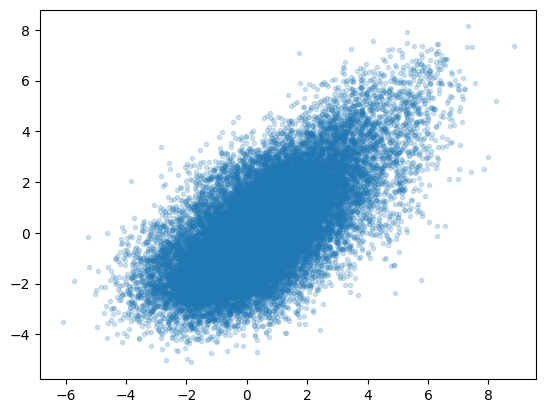

In [16]:
subset = merged#.query('strategy == "empty"')

pyplot.plot(subset['text_score'], subset['image_score'], '.', alpha=0.2)

In [17]:
# pyplot.figure(figsize=(10, 4))

# pyplot.subplot(1, 2, 1)

# _ = pyplot.hist(subset[::10]['image_score'], bins=100)
# pyplot.title(f'vision score before RLHF average: {subset["image_score"].mean():.4f}')

# pyplot.subplot(1, 2, 2)

# _ = pyplot.hist(ss[::3]['image_score'], bins=100)
# pyplot.title(f'vision score after RLHF average: {ss["image_score"].mean():.4f}')

In [49]:
std = subset['image_score'].std()
mean = subset['image_score'].mean()

selected_s = dict()

for i in range(-4, 5):
    
    th_min, th_max = mean + (i - 0.5) * std, mean + (i + 0.5) * std
    
    selected = subset.query(f'image_score > {th_min} and image_score < {th_max}')
    if selected.shape[0] < 16:
        continue
    
    selected_s[i] = np.random.choice(selected.index, 9, False)

In [50]:
dfs = list()

for sigma, indices in selected_s.items():
    
    df = merged.loc[indices].copy()
    df['sigma'] = sigma
    
    dfs.append(df)
    
    os.makedirs(f'./selected/{sigma}', exist_ok=True)
    
    for file_name in indices:
        
        os.system(f'cp ./generated/image/{file_name} ./selected/{sigma}')
        
dfs = pd.concat(dfs)
dfs.to_csv('./selected/prompts.tsv', sep='\t')

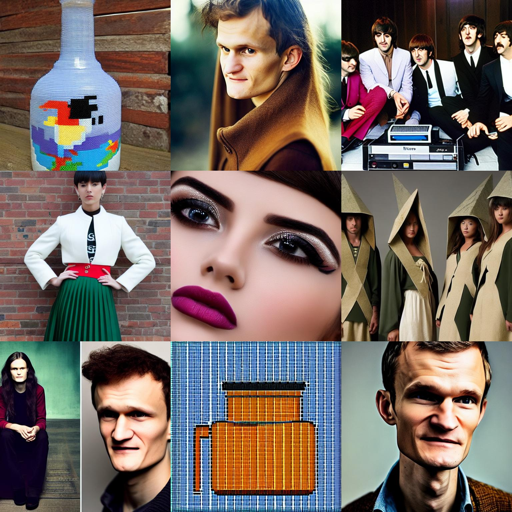

In [101]:
n_select = 9

# selected = subset.sort_values('text_score').tail(n_select)
selected = subset.loc[subset.eval('text_score - image_score').sort_values().tail(n_select).index]

show_images([os.path.join(OUTPUT_DIR, 'image', i) for i in selected.index])

In [102]:
selected

,positive_length,negative_length,positive_prompt,negative_prompt,positive_base,negative_base,strategy,positive_score,negative_score,text_score,image_score
file_name,,,,,,,,,,,
55926b3c760d07f656e5379ecefc86e2d46351dbce8794e2d0292be3bb52523e.jpg,short,short,a jug of moonshine made out of rubber in a zoo...,"medium quality, watermark, text, signature;",-,-,empty,4.403921,0.962400,5.048780,0.169307
bd76efa39b7d301f1130f31bfe06db203e127a3db2f9ad6e0934bc757deaefb5.jpg,medium,medium,"vitalik buterin, realistic portrait photograph...","full body, 3d render, ugly eyes, bad anatomy, ...",-,-,empty,1.644034,0.440751,2.083327,-2.872133
89f8e5776387fbb8edc1f52216db6418221c02ea7f79d8f677d06a5a58180643.jpg,short,short,the beatles playing in a playstation 1 game;,"full body, blurry, cartoon image, bad anatomy,...",-,-,empty,2.929157,1.049720,3.278243,-1.702176
024ab76751dfbba6feac2847c0dc1c2bffd0039e4ff891162f75e804aebc8cd0.jpg,long,long,"masterpiece, best quality, highres, 1girl amne...","medium quality, lowres, bad anatomy, worst qua...",-,-,empty,0.223836,1.489256,1.288652,-3.752205
ab5de09af2fb71829a663aa544355e0bc92a3454729321f8190bd9c5ecf6e85a.jpg,full,full,"ultra realistic 8k cg, picture-perfect face, f...","medium quality, lowres, easynegative, badhandv...",-,-,empty,1.038423,0.827680,1.644929,-3.424333
2c803694bac3cd5a11e20ee9f0fd6ab7bb5c396f0aeada4f02b0864792933343.jpg,short,short,"a group of people with a pyramid head, in the ...","medium quality, watermark, text, signature;",-,-,empty,1.567894,0.962400,2.332467,-2.791141
f5dba9eb9df5915142be6c36c340de14d8c0a2d7021b97bb5e9bd1ec1658b65a.jpg,medium,medium,"vitalik buterin, realistic portrait photograph...",short legs malformed legs weird pose legs thro...,-,-,empty,1.644034,0.895865,2.452464,-3.019761
7f9e94330928ac3a54d48bb71ba5f52e819c20fd2f82ff3c2155d8c1b4725c25.jpg,short,short,a jug of moonshine made out of rubber in a zoo...,"medium quality, bad anatomy, disfigured, poorl...",-,-,empty,4.403921,0.921662,4.805916,-0.696868
19d6fb0801d72fadc071bf793563f43af96854806baea42dbd81e7e6cb3440bf.jpg,medium,medium,"vitalik buterin, realistic portrait photograph...","short hair, no makeup, half face, ugly obese f...",-,-,empty,1.644034,1.327387,3.416258,-3.169731


In [89]:
# list(map(tuple, selected[['positive_prompt', 'negative_prompt']].itertuples(index=False)))